<a href="https://colab.research.google.com/github/yuliiabosher/Adam_Smith_project/blob/main/Visualisations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [158]:
!pip install nltk
!pip install nxviz

In [159]:
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import collections
from gensim.corpora.dictionary import Dictionary
from gensim.models.tfidfmodel import TfidfModel
import itertools
from textblob import TextBlob
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.feature_extraction.text import CountVectorizer, ENGLISH_STOP_WORDS
import networkx as nx
import nxviz as nv
from nxviz import annotate
import seaborn as sns
import numpy as np
from PIL import Image
import warnings
warnings.filterwarnings("ignore")

nltk.download("punkt")
nltk.download("averaged_perceptron_tagger")
nltk.download('maxent_ne_chunker')
nltk.download('words')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [160]:
def month_to_number(month):
  months = {"january": "1", "february": "2", "march": "3", "april": "4", "may": "5", "june": "6", "july": "7", \
            "august": "8", "september": "9", "october": "10", "november": "11", "december": "12"}
  month = month.lower()
  numerical = months[month]
  return numerical

def to_date(string):
  elements = string.split(',')
  year = elements[-1].strip()
  month, day = elements[-2].split()
  month = month_to_number(month)
  date = f'{year}-{month}-{day}'
  return date

In [161]:
def clean_df(df):
  df = pd.read_excel(df)
  df = df.fillna('n/a')
  df = df.drop(df[df['Mention of Adam smith'].str.contains('NA')].index)
  df = df.drop(df[df['Mention of Adam smith'].str.contains('n/a')].index)
  df.columns = ['Date', 'Extract', 'Notes', 'Notes2', 'About Adam Smith', 'Rep']
  dates = []
  for index, row in df.iterrows():
    dates.append(to_date(row['Date']))
  df['Date'] = dates
  df['Date'] = pd.to_datetime(df['Date'])
  df = df.set_index('Date').sort_index()
  df = df.drop('Notes', axis=1)
  df = df.drop('Notes2', axis=1)
  df = df.drop('About Adam Smith', axis=1)
  return df
df = clean_df('https://github.com/yuliiabosher/Adam_Smith_project/raw/main/adam_smith.xlsx')
display(df.head())

,Extract,Rep
Date,,
1995-05-23,"As everybody knows, a little earlier this year...",Peter Anthony DeFazio\nDemocratic Party
1996-05-23,"Mr. GENE GREEN of Texas. Mr. Speaker, to my co...",Raymond Eugene “Gene” Green\n Democratic Party
1996-05-23,"When wages fall, buying power drops, and all t...",Ronald Paul Klink\nDemocratic Party
1999-10-13,These arguments are no truer today than they w...,Paul David Wellstone\nDemocratic Party
1999-10-27,Go right back to Alexander Hamilton in the ear...,Ernest Frederick “Fritz” Hollings\nDemocratic ...


In [162]:
def clean_rep_data(df):
  rep = []
  for index, row in df.iterrows():
    if row['Rep'].strip() != 'PRESIDENT BUSH':
      rep.append(row['Rep'].strip().splitlines())
    else:
      rep.append(['President Bush', 'Republican Party'])
  rep_with_numbers = list(enumerate(rep))
  rep[106] = ['Alvin H. Perlmutter', 'Other']
  rep[99] = ['Not known', 'Other']
  rep[100] = ['Not known', 'Other']
  rep[83] = ['William Wilson', 'Other']
  rep[70] = ['Daniel Benjamin Maffei\xa0', 'Democratic Party']
  rep[66] =  ['Bill Etheridge', 'Other']
  rep[55] = ['Brad Sherman', 'Democratic Party']
  rep[56] = ['Brad Sherman', 'Democratic Party']
  rep[38] =  ['Tim Walz', 'Other']
  rep[82] = ['Keith Maurice Ellison', 'Other']
  rep[93] = ['n/a', 'n/a']
  df['Representative'] = [x[0] for x in rep]
  party = [x[1] for x in rep]
  for i in range(len(party)):
    if 'Democratic' in party[i]:
      party[i] = 'Democrats'
    elif 'Republican' in party[i]:
      party[i] = 'Republicans'
    else:
      pass
  df['Party'] = party
  df = df.drop(df[df['Party'] == 'n/a'].index, axis=0)
  df = df.drop('Rep', axis=1)
  return df
df = clean_rep_data(df)
display(df.head())

,Extract,Representative,Party
Date,,,
1995-05-23,"As everybody knows, a little earlier this year...",Peter Anthony DeFazio,Democrats
1996-05-23,"Mr. GENE GREEN of Texas. Mr. Speaker, to my co...",Raymond Eugene “Gene” Green,Democrats
1996-05-23,"When wages fall, buying power drops, and all t...",Ronald Paul Klink,Democrats
1999-10-13,These arguments are no truer today than they w...,Paul David Wellstone,Democrats
1999-10-27,Go right back to Alexander Hamilton in the ear...,Ernest Frederick “Fritz” Hollings,Democrats


In [163]:
def create_dates_list(df):
  return df.index
create_dates_list(df)

DatetimeIndex(['1995-05-23', '1996-05-23', '1996-05-23', '1999-10-13',
               '1999-10-27', '1999-10-28', '1999-11-01', '1999-11-02',
               '1999-11-09', '1999-11-09',
               ...
               '2019-03-07', '2019-12-10', '2020-10-01', '2020-12-21',
               '2021-03-19', '2021-10-06', '2021-10-07', '2022-07-19',
               '2022-07-26', '2023-03-09'],
              dtype='datetime64[ns]', name='Date', length=106, freq=None)

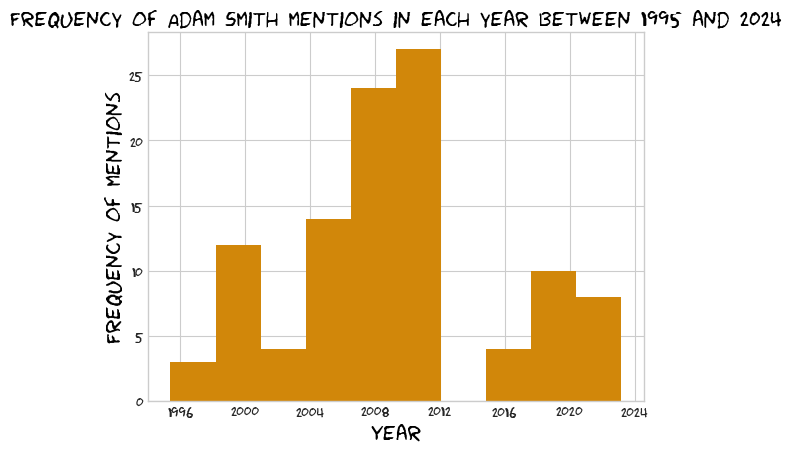

In [164]:
def create_histogram(df):
  plt.style.use('seaborn-v0_8-whitegrid')
  plt.hist(df.index, color='#D1870A')
  font = {'family':'fantasy','color':'black','size':15}
  plt.xticks(fontname="fantasy")
  plt.yticks(fontname="fantasy")
  plt.xlabel('Year', fontdict = font)
  plt.ylabel('Frequency of mentions', fontdict = font)
  plt.title('Frequency of Adam Smith mentions in each year between 1995 and 2024', fontdict = font)
  plt.show()

create_histogram(df)

In [165]:
def tokenize_df(df):
  tokens = [nltk.word_tokenize(row['Extract']) for index, row in df.iterrows()]
  return tokens

token_list = tokenize_df(df)
print(token_list[0][:10])

['As', 'everybody', 'knows', ',', 'a', 'little', 'earlier', 'this', 'year', ',']


In [166]:
def preprocess_tokens(list_of_lists):
  lower_tokens = [[t.lower()for t in nested_list] for nested_list in list_of_lists]
  alpha_num_only = [[t for t in token_list if t.isalnum()] for token_list in lower_tokens]
  stopwords = nltk.corpus.stopwords.words('english')
  stopwords.extend(['adam', 'smith', 'u', 'would', 'wrote'])
  no_stops = [[t for t in alpha_list if t not in stopwords] for alpha_list in alpha_num_only]
  wordnet_lemmatizer = nltk.stem.WordNetLemmatizer()
  lemmatized = [[wordnet_lemmatizer.lemmatize(t) for t in no_stops_list] for no_stops_list in no_stops]
  return lemmatized
preprocessed = preprocess_tokens(token_list)
print(preprocessed[0][:10])

['everybody', 'know', 'little', 'earlier', 'year', 'part', 'record', 'trade', 'deficit', 'led']


In [167]:
def create_corpus(preprocessed_data):
  dictionary = Dictionary(preprocessed)
  corpus = [dictionary.doc2bow(article) for article in preprocessed]
  return dictionary, corpus

dictionary, corpus = create_corpus(preprocessed)
print(corpus[0][:10])

[(0, 1), (1, 1), (2, 1), (3, 2), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1)]


In [168]:
def find_most_frequently_occuring_pairs(corpus):
  word_id_list_of_lists = [[i[0] for i in j] for j in corpus]
  pair_list_of_lists = [list(itertools.combinations(nested_list,2)) for nested_list in word_id_list_of_lists]
  catalogue_of_occurences = collections.defaultdict(int)
  for list_of_pairs in pair_list_of_lists:
    for pair in list_of_pairs:
      catalogue_of_occurences[pair]+=1
  most_frequently_occuring_pairs = sorted(list(catalogue_of_occurences.items()), key=lambda x: x[1], reverse=True)
  return most_frequently_occuring_pairs
most_frequently_occuring_pairs = find_most_frequently_occuring_pairs(corpus)
print(most_frequently_occuring_pairs[:10])

[((332, 337), 25), ((125, 136), 21), ((125, 332), 16), ((337, 397), 15), ((125, 337), 14), ((127, 132), 13), ((332, 397), 12), ((136, 337), 11), ((125, 176), 10), ((55, 125), 10)]


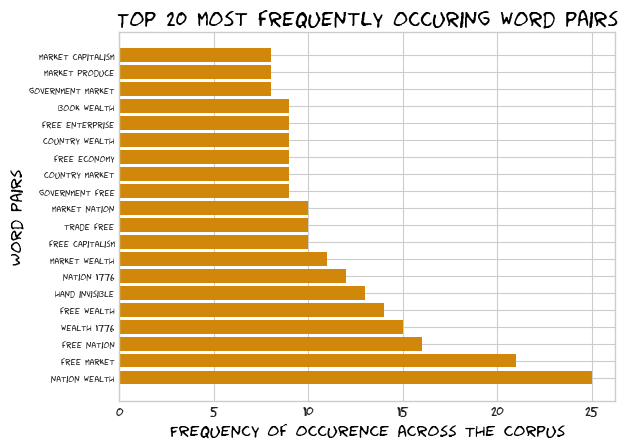

In [169]:
def plot_most_frequent_pairs(df):
  most_frequent_pairs = []
  frequency = []
  for nested_tuple in most_frequently_occuring_pairs[:20]:
    concatenated_string = f'{dictionary.get(nested_tuple[0][0])} {dictionary.get(nested_tuple[0][1])}'
    most_frequent_pairs.append(concatenated_string)
    frequency.append(nested_tuple[1])
  f = plt.barh(most_frequent_pairs,frequency, color='#D1870A')
  font = {'family':'fantasy','color':'black','size':15}
  plt.yticks(fontname="fantasy", fontsize=6)
  plt.xticks(fontname="fantasy")
  plt.ylabel('Word pairs', fontdict = {'family':'fantasy','color':'black','size': 12})
  plt.xlabel('Frequency of occurence across the corpus', fontdict = {'family':'fantasy','color':'black','size': 12})
  plt.title('Top 20 most frequently occuring word pairs', fontdict = font)
  plt.show()
plot_most_frequent_pairs(df)

In [170]:
def word_count_desc(corpus):
  total_word_count = collections.defaultdict(int)
  for word_id, word_count in itertools.chain.from_iterable(corpus):
      total_word_count[word_id] += word_count
  sorted_word_count = sorted(total_word_count.items(), key=lambda w: w[1], reverse=True)
  return sorted_word_count

sorted_word_count = word_count_desc(corpus)
print(sorted_word_count[:10])

[(136, 60), (125, 50), (332, 38), (337, 36), (96, 27), (55, 26), (319, 24), (10, 22), (62, 22), (176, 22)]


In [171]:
for word_id, word_count in sorted_word_count[:20]:
    print(dictionary.get(word_id), word_count)

market 60
free 50
nation 38
wealth 36
government 27
trade 26
people 24
country 22
year 22
capitalism 22
hand 20
one 20
produce 19
world 18
u 18
invisible 18
going 18
1776 18
cost 18
back 17


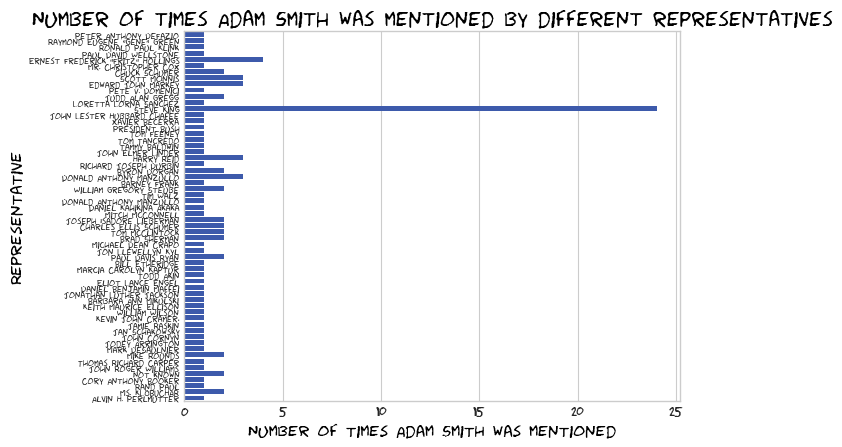

In [172]:
def create_rep_countplot(df):
  f = sns.countplot(data=df, y='Representative', color='#2a52be')
  font = {'family':'fantasy','color':'black','size':15}
  plt.yticks(fontname="fantasy", fontsize=6)
  plt.xticks(fontname="fantasy")
  plt.ylabel('Representative', fontdict = {'family':'fantasy','color':'black','size': 12})
  plt.xlabel('Number of times Adam Smith was mentioned', fontdict = {'family':'fantasy','color':'black','size': 12})
  plt.title('Number of times Adam Smith was mentioned by different representatives', fontdict = font)
  plt.show()
create_rep_countplot(df)

In [173]:
def calculate_weight_of_words(corpus):
  try:
    tfidf = TfidfModel(corpus)
    all_tfidf_weights = []
    i=0
    while tfidf[corpus[i]]:
      tfidf_weights = tfidf[corpus[i]]
      all_tfidf_weights.append(tfidf_weights)
      i+=1
    return all_tfidf_weights
  except IndexError:
    return all_tfidf_weights

all_tfidf_weights = calculate_weight_of_words(corpus)
for term_id, weight in all_tfidf_weights[0][:20]:
  print(dictionary.get(term_id), weight)

1980 0.1208342542274754
200 0.1028741348943879
airplane 0.1208342542274754
america 0.11740489906418695
basket 0.1208342542274754
bit 0.1028741348943879
britain 0.09236813857605464
came 0.1028741348943879
case 0.1208342542274754
continue 0.0849140155613004
country 0.04594190359154638
dead 0.1208342542274754
deficit 0.1208342542274754
dictate 0.2416685084549508
dollar 0.2057482697887758
doorstep 0.1208342542274754
earlier 0.1208342542274754
early 0.07913214856044985
economist 0.05245370548390275
engine 0.1208342542274754


In [174]:
def add_extract_length(df):
  df['Extract length'] = df['Extract'].str.len()
  return df
df = add_extract_length(df)
display(df.tail())

,Extract,Representative,Party,Extract length
Date,,,,
2021-10-06,We are a nation that exploded forth to be the ...,Cory Anthony Booker,Democrats,273
2021-10-07,That was 98 percent of the world. Fast-forward...,Rand Paul,Republicans,593
2022-07-19,"You go back, way back, to the godfather of cap...",Ms. KLOBUCHAR,Democrats,298
2022-07-26,"adam Smith—the godfather of capitalism, the gu...",Ms. KLOBUCHAR,Democrats,367
2023-03-09,Adam Smith’s Money World,Alvin H. Perlmutter,Other,24


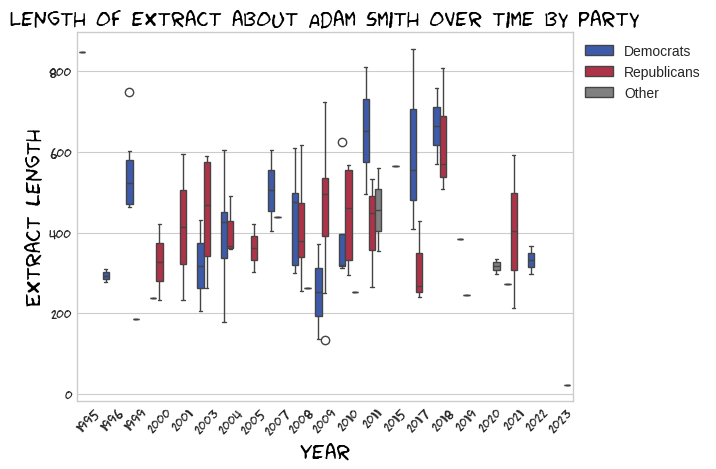

In [175]:
def create_boxplots_of_text_length(df):
  g = sns.boxplot(x=df.index.year, y=df['Extract length'], hue=df['Party'], palette=['#2a52be', '#C41E3A', 'grey', 'black'])
  plt.legend(bbox_to_anchor = [1.0, 1.0])
  font = {'family':'fantasy','color':'black','size':15}
  plt.xticks(fontname="fantasy", rotation=45)
  plt.yticks(fontname="fantasy")
  plt.xlabel('Year', fontdict = font)
  plt.ylabel('Extract length', fontdict = font)
  plt.title('Length of extract about Adam Smith over time by party', fontdict = font)
  plt.show()
create_boxplots_of_text_length(df)

In [176]:
def check_sentiment(df):
  polarity = []
  subjectivity = []
  for index, row in df.iterrows():
    sentiment = TextBlob(row['Extract'])
    polarity.append(sentiment.polarity)
    subjectivity.append(sentiment.subjectivity)
  df['Polarity'] = polarity
  df['Subjectivity'] = subjectivity
  return df

df_sentiments = check_sentiment(df)
display(df_sentiments.head())

,Extract,Representative,Party,Extract length,Polarity,Subjectivity
Date,,,,,,
1995-05-23,"As everybody knows, a little earlier this year...",Peter Anthony DeFazio,Democrats,847,0.034375,0.404167
1996-05-23,"Mr. GENE GREEN of Texas. Mr. Speaker, to my co...",Raymond Eugene “Gene” Green,Democrats,277,0.166667,0.400000
1996-05-23,"When wages fall, buying power drops, and all t...",Ronald Paul Klink,Democrats,310,0.383333,0.391667
1999-10-13,These arguments are no truer today than they w...,Paul David Wellstone,Democrats,748,0.055417,0.514167
1999-10-27,Go right back to Alexander Hamilton in the ear...,Ernest Frederick “Fritz” Hollings,Democrats,464,0.183036,0.222619


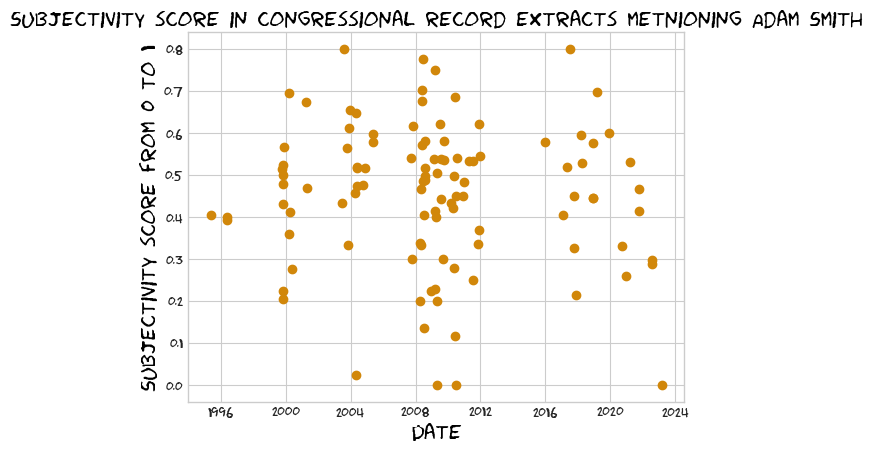

In [177]:
def plot_subjectivity_score(df):
  plt.scatter(df.index, df['Subjectivity'], color='#D1870A')
  font = {'family':'fantasy','color':'black','size':15}
  plt.xticks(fontname="fantasy")
  plt.yticks(fontname="fantasy")
  plt.ylabel('Subjectivity score from 0 to 1', fontdict = font)
  plt.xlabel('Date', fontdict = font)
  plt.title('Subjectivity score in congressional record extracts metnioning Adam Smith', fontdict = font)
  plt.show()
plot_subjectivity_score(df_sentiments)

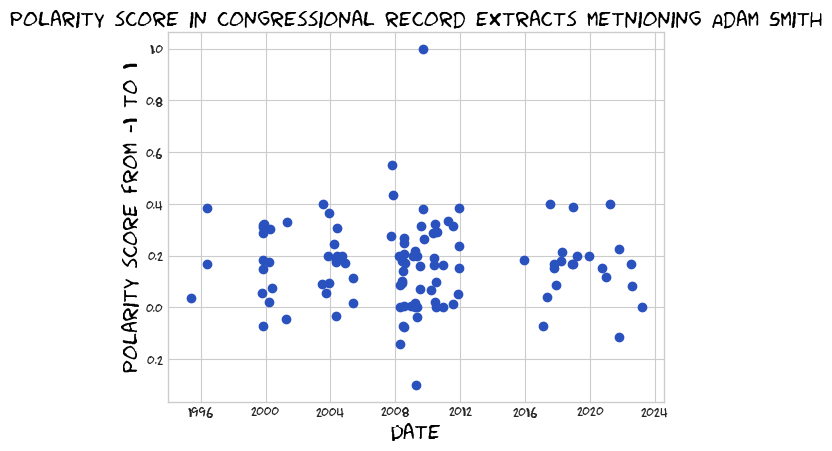

In [178]:
def plot_polarity_score(df):
  plt.scatter(df.index, df['Polarity'], color='#2a52be')
  font = {'family':'fantasy','color':'black','size':15}
  plt.xticks(fontname="fantasy")
  plt.yticks(fontname="fantasy")
  plt.ylabel('Polarity score from -1 to 1', fontdict = font)
  plt.xlabel('Date', fontdict = font)
  plt.title('Polarity score in congressional record extracts metnioning Adam Smith', fontdict = font)
  plt.show()
plot_polarity_score(df_sentiments)

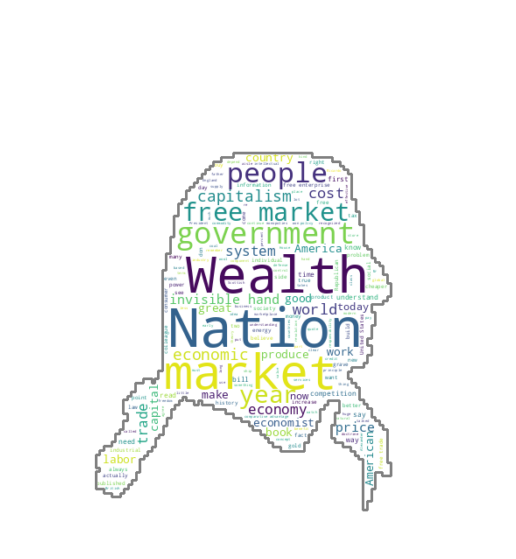

In [179]:
def word_cloud(df):
  stopwords = set(STOPWORDS)
  stopwords.update(['s', 't', 'Adam', 'Smith', 'will', 'let', 'go', 'one', 'take', 'u', 'said', 'wrote', 'going', 'think', 'back', 'never', 'us', 'well'])
  mask = np.array(Image.open("/content/mask.png"))
  image_colors = ImageColorGenerator(mask)
  plt.figure(figsize=[7,7])
  text = ""
  for index, row in df.iterrows():
    text += " "
    text += row['Extract']
  word_cloud = WordCloud(stopwords=stopwords, background_color="white", max_words=1000, mask=mask, contour_width=2, contour_color='grey').generate(text)
  plt.imshow(word_cloud, interpolation='bilinear')
  plt.axis('off')
  plt.show()
word_cloud(df)

In [180]:
def bow_with_ngrams(df):
  my_stop_words = list(ENGLISH_STOP_WORDS.union(['adam', 'smith', 'speaker', 'don', 'seen', 'smith' 'wrote', 'actually', 'mr speaker', 'sure', 'said']))
  vect = CountVectorizer(ngram_range=(1, 2), max_features=200, stop_words=my_stop_words)
  vect.fit(df.Extract)
  X_extract = vect.transform(df.Extract)
  X_df=pd.DataFrame(X_extract.toarray(), columns=vect.get_feature_names_out())
  return X_df
display(bow_with_ngrams(df).columns)
bow_bigrams = bow_with_ngrams(df).head()
print(bow_bigrams)

Index(['1776', 'able', 'advantage', 'agree', 'aisle', 'amendment', 'america',
       'american', 'americans', 'base',
       ...
       'won', 'wool', 'work', 'works', 'world', 'wrong', 'wrote', 'year',
       'year 1776', 'years'],
      dtype='object', length=200)

   1776  able  advantage  agree  aisle  amendment  america  american  \
0     0     0          0      0      0          0        2         0   
1     0     0          0      0      0          0        0         0   
2     0     0          0      0      0          0        0         0   
3     0     0          0      0      0          0        0         0   
4     0     0          2      0      0          0        0         0   

   americans  base  ...  won  wool  work  works  world  wrong  wrote  year  \
0          0     0  ...    0     0     0      0      2      0      0     1   
1          0     0  ...    0     0     0      0      1      0      0     0   
2          0     0  ...    0     0     0      0      0      0      0     0   
3          0     0  ...    0     0     0      0      0      0      0     0   
4          0     0  ...    1     0     0      0      0      0      0     0   

   year 1776  years  
0          0      1  
1          0      0  
2          0      0  
3         